In [63]:
from graphein.protein.config import ProteinGraphConfig
from graphein.protein.edges.distance import *
from graphein.protein.graphs import construct_graph
from graphein.protein.visualisation import plotly_protein_structure_graph
from utils import *
from networkx import adjacency_matrix
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
from IPython.display import clear_output


edge_fns = [
    add_aromatic_interactions,
    add_hydrophobic_interactions,
    add_aromatic_sulphur_interactions,
    add_cation_pi_interactions,
    add_disulfide_interactions,
    add_hydrogen_bond_interactions,
    add_ionic_interactions,
    add_peptide_bonds
    ]
config = ProteinGraphConfig(edge_construction_functions=edge_fns)



In [3]:
df = create_graph_df(config =config)
clear_output()

In [33]:
set1 = set(df['graph_allele1'])
set2 = set(df['graph_allele2'])
set_total = set1 | set2
graphs = list(set_total)

In [34]:
len(graphs)

45

In [35]:
graphs = [g for g in graphs if g is not None]
graphs

In [7]:
adjacency_matrices = [ adjacency_matrix(graph, weight='distance') for graph in graphs]
# convert to csr_matrix
adjacency_matrices = [csr_matrix(m) for  m in adjacency_matrices]


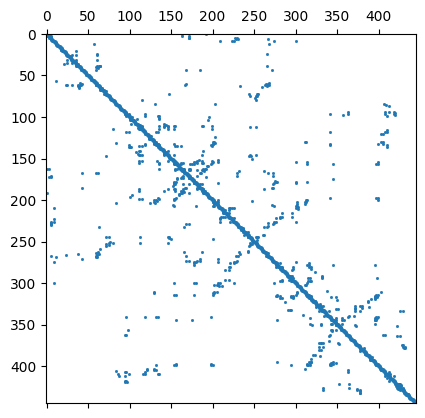

In [8]:
# spy one adjacency matrix
plt.spy(adjacency_matrices[3], ms=1)

In [9]:
nodes =list(graphs[0].nodes(data=True))


In [10]:
nodes[0][1]['coords']

array([ -9.148, -22.172,   9.305])

In [11]:
def chamfer_distance(g1, g2):
    """
    Chamfer distance between two graphs
    """
    coords1 = np.array([node['coords'] for i, node in g1.nodes(data=True)])
    coords2 = np.array([node['coords'] for i, node in g2.nodes(data=True)])
    tree = KDTree(coords1)
    dist_2 = tree.query(coords2)[0]
    tree = KDTree(coords2)
    dist_1 = tree.query(coords1)[0]
    return np.mean(dist_1) + np.mean(dist_2)

In [12]:
def chamfer_matrix(graphs_list):
    n = len(graphs_list)
    M = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            M[i, j] = chamfer_distance(graphs_list[i], graphs_list[j])
            M[j, i] = M[i, j]

    return M

In [13]:
M=chamfer_matrix(graphs)

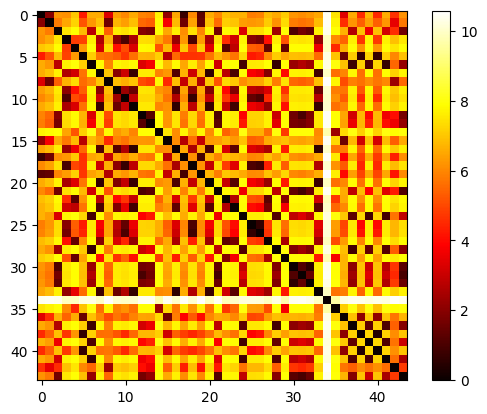

In [18]:
plt.imshow(M, cmap='hot')
plt.colorbar()
plt.show()

In [19]:
def k_medoids(M, k, max_iter=100):
    n = M.shape[0]
    medoids = np.random.choice(n, k, replace=False)
    clusters = np.argmin(M[medoids], axis=0)
    for _ in range(max_iter):
        for i in range(k):
            medoids[i] = np.argmin(np.sum(M[np.ix_(clusters == i, clusters == i)], axis=1))
        new_clusters = np.argmin(M[medoids], axis=0)
        if np.array_equal(clusters, new_clusters):
            break
        clusters = new_clusters
    return medoids, clusters

In [20]:
k = 3
medoids, clusters = k_medoids(M, k)


In [21]:
medoids

array([ 5,  0, 13])

In [22]:
clusters


array([1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 1, 0, 2,
       0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 2],
      dtype=int64)

In [27]:
sse = np.sum([M[medoids[i], clusters == i].sum() for i in range(k)])
silhouette = np.mean([np.mean(M[clusters == i][:, clusters == i].sum(axis=1)) for i in range(k)])

In [28]:
silhouette

49.42464980741921

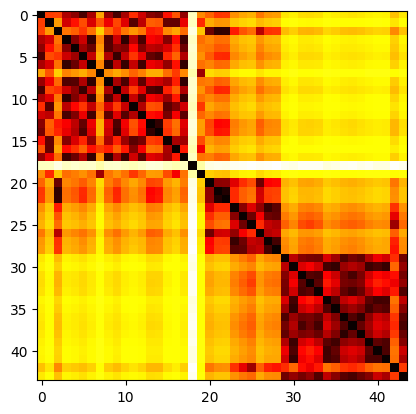

In [59]:
# reorder the graphs according to the clusters
ordered_graphs = [g for (g,_) in sorted(zip(graphs, clusters),  key=lambda pair: pair[1])]
ordered_graphs
chamfer_matrix_prd = chamfer_matrix(ordered_graphs)
plt.imshow(chamfer_matrix_prd, cmap='hot')

In [62]:
count =0
for node in graphs[2].nodes(data=True):
    coords1 = node[1]['coords']
    best = -1
    best_dist = 1e9
    for node2 in graphs[27].nodes(data=True):
        coords2 = node2[1]['coords']
        dist = np.linalg.norm(coords1 - coords2)
        if dist < best_dist:
            best = node2
            best_dist = dist
    if node[1]['residue_number'] != best[1]['residue_number']:
        count +=1
        print(node[1]['residue_number'], best[1]['residue_number'])
count

1 140
2 140
3 193
4 192
5 191
6 164
7 1
8 173
9 173
10 173
11 228
12 5
13 5
14 4
15 233
16 233
17 235
18 235
19 237
20 237
21 237
22 235
23 20
24 236
25 20
26 20
27 20
28 19
29 22
30 22
31 24
32 21
33 37
34 37
35 37
36 236
37 236
38 236
39 64
40 64
41 266
42 62
43 268
44 268
45 269
46 273
47 13
48 13
49 14
50 13
51 13
52 9
53 7
54 8
55 9
56 14
57 7
58 16
59 232
60 232
61 265
62 234
63 264
66 65
67 66
68 42
69 66
70 68
71 68
72 68
73 68
74 150
75 126
76 126
77 126
78 126
79 126
80 124
81 125
82 129
83 129
84 306
85 306
86 307
87 306
88 307
89 307
90 307
91 338
92 338
93 338
94 337
95 367
96 366
97 366
98 91
99 408
100 408
101 409
102 409
103 82
104 410
105 79
106 79
107 87
108 82
109 78
110 252
111 252
112 248
113 248
114 251
115 251
116 132
117 131
118 130
119 404
120 312
121 312
122 304
123 304
124 306
125 206
126 55
127 55
128 55
129 209
130 304
131 303
132 303
133 313
134 131
135 132
136 132
137 118
138 81
139 80
140 78
141 78
142 253
143 255
144 255
145 247
146 247
147 148
148 185


428

In [67]:
plotly_protein_structure_graph(graphs[2])


In [66]:
plotly_protein_structure_graph(graphs[27])